### Pre-split analysis

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

pd.set_option("display.max_columns", 500)

np.random.seed(2024)

In [109]:
bottle_data_path = '../data/bottle'

In [110]:
bottle_df = pd.read_csv(f'{bottle_data_path}/bottle_01.csv', index_col=0)

In [111]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536965 entries, 0 to 536964
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_Depth     536965 non-null  float64
 1   R_TEMP      529623 non-null  float64
 2   R_SALINITY  510592 non-null  float64
 3   R_SIGMA     507018 non-null  float64
 4   R_SVA       507022 non-null  float64
 5   R_DYNHT     514582 non-null  float64
 6   R_O2        406502 non-null  float64
 7   R_O2Sat     391582 non-null  float64
 8   R_SIO3      221752 non-null  float64
 9   R_PO4       247420 non-null  float64
 10  R_NO3       210148 non-null  float64
 11  R_NO2       209708 non-null  float64
 12  R_NH4       43565 non-null   float64
 13  R_CHLA      147881 non-null  float64
 14  R_PHAEO     147847 non-null  float64
 15  R_PRES      536965 non-null  float64
dtypes: float64(16)
memory usage: 69.6 MB


In [112]:
bottle_df.count().sort_values()

R_NH4          43565
R_PHAEO       147847
R_CHLA        147881
R_NO2         209708
R_NO3         210148
R_SIO3        221752
R_PO4         247420
R_O2Sat       391582
R_O2          406502
R_SIGMA       507018
R_SVA         507022
R_SALINITY    510592
R_DYNHT       514582
R_TEMP        529623
R_Depth       536965
R_PRES        536965
dtype: int64

#### Distributions

Before doing train/test split, I would like to investigate a bit the distribution of columns in order to see if further adjustments are needed.

In [113]:
def hist_plot(X, f_size=(5, 3)):
    plt.figure(figsize=f_size)
    sns.histplot(data=X, kde=False, bins=50)
    plt.plot()

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

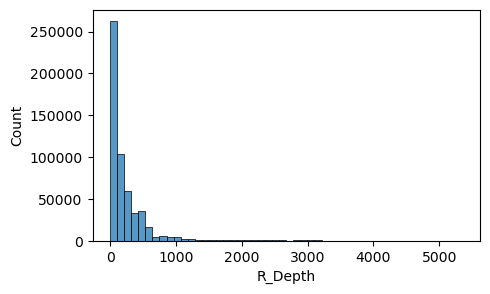

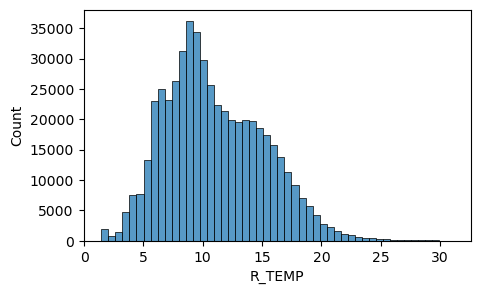

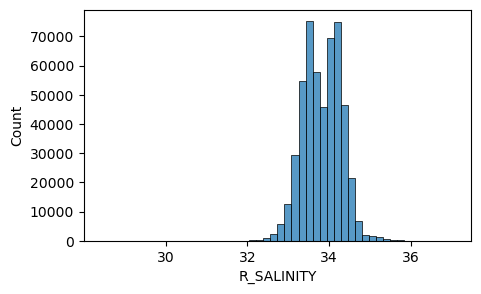

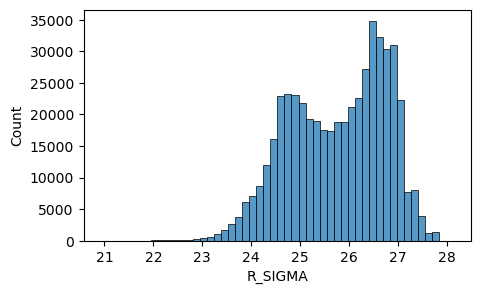

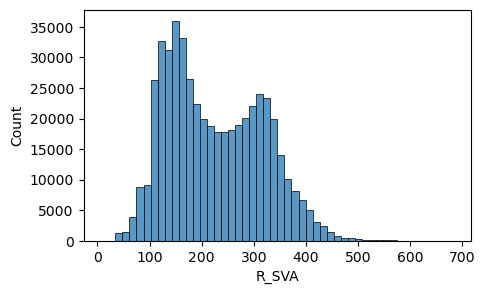

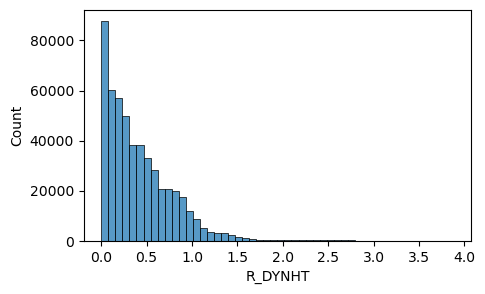

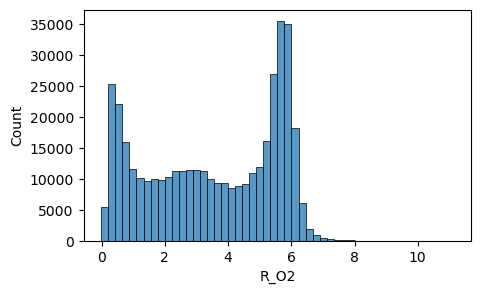

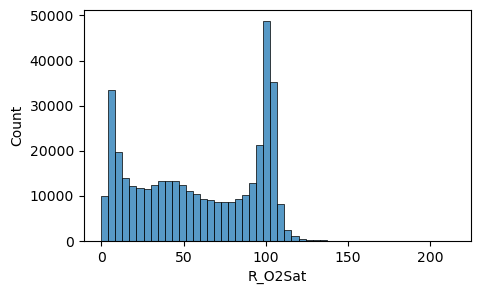

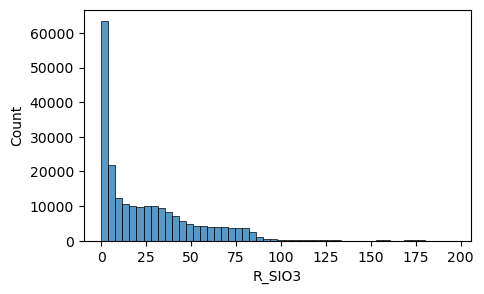

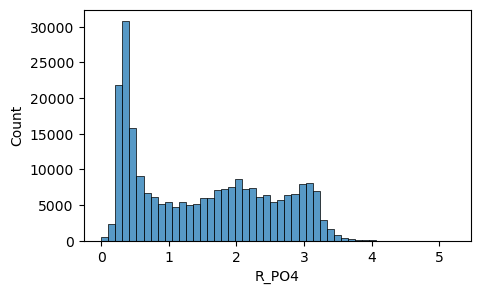

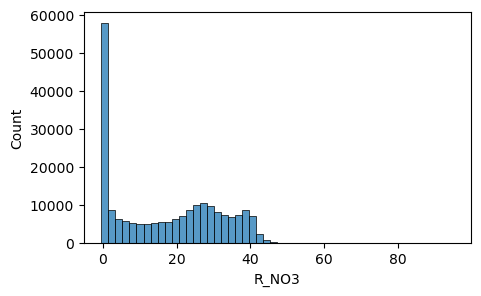

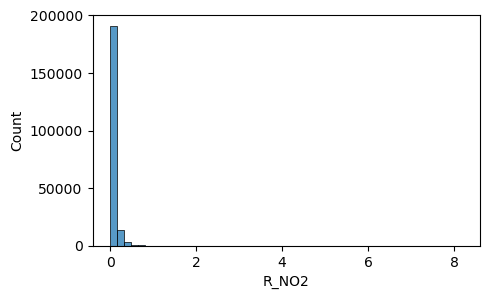

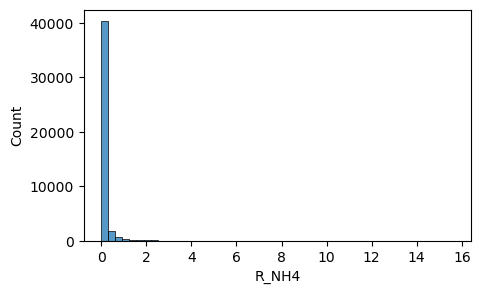

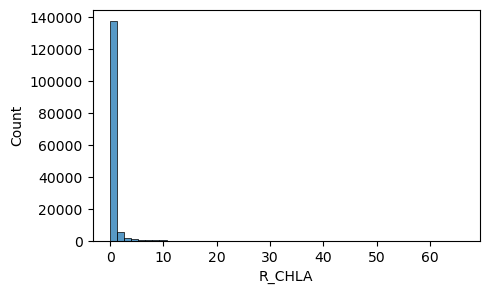

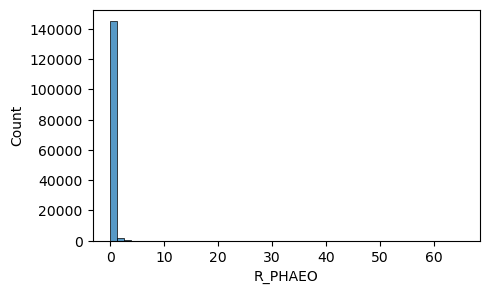

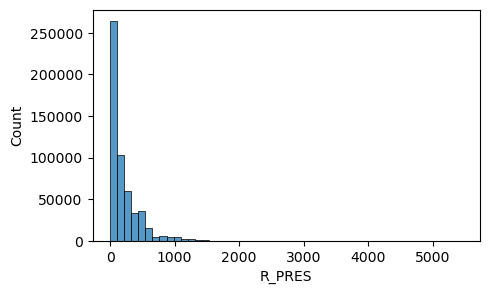

In [114]:
for col in bottle_df.columns:
    hist_plot(bottle_df[col])

Some of the columns have two "modes" in their distributions. I think it is because of geographic location (California Coast VS Bay of California). NEED TO CHECK THIS!!! (add geographic data from Cast table).

Also, there are clear candidates for categorical features, e.g. R_PHAEO, where most of the values fall in the first near-zero bucket. I can work with this by creating new features. Then we can use classification algorithms for these variables, although a lot of NaNs can be a problem here (just an idea).